---
#Notebook #3: Clasificación de imágenes y almacenamiento en base de datos
---

Este notebook forma parte del trabajo de fin de grado realizado por:

*  Daniel Arnaiz Gutierrez 

Con la colaboración de los tutores:

*  José Franciso Díez Pastor
*  Cesar Ignacio Garcıa Osorio

El resto de este proyecto se puede encontrar en el siguiente repositorio de GitHub: [TFG-Amazon-Scraper](https://github.com/daniarnaizg/TFG-Amazon-Scraper)

En la parte izquierda de esta ventana se encuentra la tabla de contenido de este notebook.

---
#  Importación de los clasificadores ya entrenados

Para poder usar los clasificadores que hemos entrenado previamente, es necesario  descargarlos desde el repositorio y cargarlos con la función load_model de Keras.

In [1]:
# Descargamos los clasificadores ya entrenados.
!wget https://github.com/daniarnaizg/TFG-Amazon-Scraper/raw/master/keras_models/clasificador-modelos.h5
!wget https://github.com/daniarnaizg/TFG-Amazon-Scraper/raw/master/keras_models/clasificador-caras.h5

--2019-07-02 18:40:40--  https://github.com/daniarnaizg/TFG-Amazon-Scraper/raw/master/keras_models/clasificador-modelos.h5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/keras_models/clasificador-modelos.h5 [following]
--2019-07-02 18:40:40--  https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/keras_models/clasificador-modelos.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33287736 (32M) [application/octet-stream]
Saving to: ‘clasificador-modelos.h5’

clasificador-modelo 100%[===================>]  31.75M   138MB/s    in 0.2s    

20

In [2]:
!ls

clasificador-caras.h5  clasificador-modelos.h5	sample_data


In [3]:
# Cargamos los modelos
from keras.models import load_model

calsificador_modelos = load_model('clasificador-modelos.h5')
calsificador_caras = load_model('clasificador-caras.h5')

Using TensorFlow backend.
W0702 18:40:53.578251 140424308135808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 18:40:53.622701 140424308135808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 18:40:53.675230 140424308135808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0702 18:40:53.678996 140424308135808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 18:40:53.680476 140424

---
# Implementación del clasificador

En esta sección se implementan las funciones utilizadas para clasificar las imágenes.
La función principal, `evaluate` se encarga de cargar la imagen, redimensionarla y convertirla en formato array. Las funciones `model_finder` y `face_finder` son las encargadas de clasificar las imágenes.

In [0]:
# Clasifica una imagen en función de si encuentr aun modelo o no con ayuda de calsificador previamente entrenado:
# 0 --> Modelo
# 1 --> Sin modelo

def model_finder(image):
    predictions = calsificador_modelos.predict(image)[0]
    return int(predictions.argmax())

In [0]:
# Clasifica una imagen en función de si encuentra una cara o no con ayuda de calsificador previamente entrenado:
# 0 --> Cara
# 1 --> Sin cara

def face_finder(image):
    predictions = calsificador_caras.predict(image)[0]
    return int(predictions.argmax())

In [0]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

def evaluate(image_dir):

    # load the image
    image = cv2.imread(image_dir)
    original = image.copy()

    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model_finder(image)
    
    final_prediction = ''
    
    if prediction is 1:
        final_prediction = "Sin modelo"
    else:
        if face_finder(image) is 0:
            final_prediction = "Modelo con cara"
        else:
            final_prediction = "Modelo sin cara"
    
    return final_prediction

---
# Productos a clasificar
La siguiente celda se encarga de descargar el archivo JSON generado por Scrapy que contiene los productos cuyas imágenes se desean clasificar:

In [7]:
# Descargamos el archivos JSON que contiene los productos a clasificar.
!wget https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/outputs/ejemplo_PRODUCTS.json

--2019-07-02 18:41:18--  https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/outputs/ejemplo_PRODUCTS.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185738 (181K) [text/plain]
Saving to: ‘ejemplo_PRODUCTS.json’

ejemplo_PRODUCTS.js 100%[===================>] 181.38K  --.-KB/s    in 0.04s   

2019-07-02 18:41:19 (4.14 MB/s) - ‘ejemplo_PRODUCTS.json’ saved [185738/185738]



---

# Descarga de imágenes

Una vez tenemos el archivo JSON hay que descargar las imágenes asociadas a cada producto. Esto se hace a través de la librería [Requests](https://2.python-requests.org//es/latest/).

Cada imagen se descarga con el código identificativo del producto al que pertenece como nombre, así podrán ser asociadas a dicho producto a la hpra de almacenarse.

In [0]:
import json, requests
from PIL import Image
from io import BytesIO

# Recorrer el json y por cada asin descargar la primera url y asociarla a su asin (nombre de la imagen descargada).
def requestImg(image_name, url):
    r = requests.get(url)
    img = Image.open(BytesIO(r.content))
    img.save("image_folder/" + image_name)
    
def downloadImage():
    with open('ejemplo_PRODUCTS.json', 'r') as f:
        data = json.load(f)
        
    for i in range(len(data)):
        try:
            url = data[i]['image_urls'][0]
            asin = data[i]['asin']
            image_name = asin + '.jpg'
            requestImg(image_name, url)
        except IndexError:
            print('Error con el producto ' +  str(i + 1) + ', continuando...')
            continue
        
    f.close()

In [0]:
!mkdir image_folder

In [10]:
downloadImage()

Error con el producto 23, continuando...


---
# Prueba manual

A continuación se clasifica una imagen cualquiera para demostrar el funcionamiento del clasificador.
Se puede cambiar la imagen a clasificar eligiendo otro código ASIN.

Predicción: Modelo sin cara


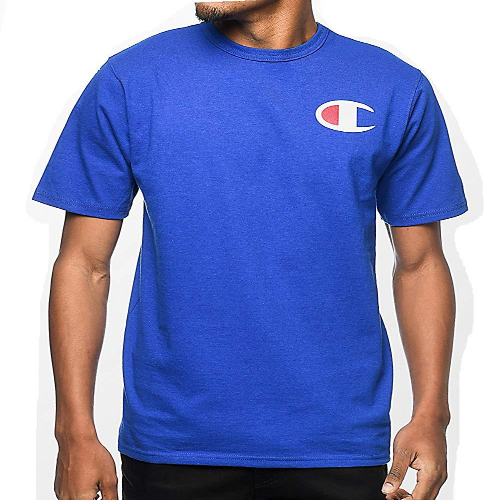

In [15]:
from google.colab.patches import cv2_imshow

image_dir = 'image_folder/B07C81DMXS.jpg'
pred = evaluate(image_dir)

print('Predicción: '+ pred)

image = cv2.imread(image_dir)
peq = cv2.resize(image, (500, 500))
cv2_imshow(peq)

---
# Descarga de base de datos

A continuación se descarga la base de datos SQLite desde el repositorio del proyecto para poder almacenar la clasificación de las imágenes.

In [16]:
# Descargamos la base de datos para poder trabajar sobre ella.
!wget https://github.com/daniarnaizg/TFG-Amazon-Scraper/raw/master/outputs/ejemplo_DB.db

--2019-07-02 18:43:44--  https://github.com/daniarnaizg/TFG-Amazon-Scraper/raw/master/outputs/ejemplo_DB.db
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/outputs/ejemplo_DB.db [following]
--2019-07-02 18:43:44--  https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/outputs/ejemplo_DB.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1257472 (1.2M) [application/octet-stream]
Saving to: ‘ejemplo_DB.db’

ejemplo_DB.db       100%[===================>]   1.20M  --.-KB/s    in 0.08s   

2019-07-02 18:43:45 (15.5 MB/s) - ‘ejemplo_DB.db’ saved [

---
#Proceso de clasificación y almacenamiento

Las siguientes funciones serán las encargadas de clasificar, una a una cada imagen, y guardar la predicción en la base de datos.
Primero se crea la conexión con la base de datos, a continuación se crea la nueva tabla llamada **'Predictions'**  y por último se itera entre todas las imágenes que hemos desargado previamente y se clasifican por medio de la función `evaluate` que hemos definido al principio del notebook.

In [0]:
# Creación de la tabla PREDICTIONS en la base de datos actual-
# También sería posible añadir este campo a la tabla MAIN_AMAZON en vez de crear una nueva tabla.
# Esta tabla se crea con vistas al futuro, como por ejemplo clasificar todas las imagenes de un prodcuto en vez de la principal.

import sqlite3

def createTables(curr):
        # self.dropAmazonTables()
        curr.execute("""CREATE TABLE IF NOT EXISTS PREDICTIONS(
                        asin TEXT FOREING KEY NOT NULL,
                        prediction TEXT
                        )""")
        
        
def storePredictionInDb(curr, conn, item):
    curr.execute("""INSERT INTO PREDICTIONS VALUES( ?, ?)""",(
        item['asin'],
        item['prediction']
        ))
    conn.commit()
    
    
def closeDB(conn):
    conn.close()

In [0]:
import json, glob
def savePredictions(curr, conn):
    
    for imagePath in glob.glob('image_folder/*.jpg'):
        item = {}
        item['asin'] = imagePath[13:23]
        item['prediction'] = evaluate(imagePath)
        
        storePredictionInDb(curr, conn, item)

In [0]:
# Creamos la conexión con la base de datos
conn = sqlite3.connect('ejemplo_DB.db')
curr = conn.cursor()

# Creamos la tabla
createTables(curr)

# Guardamos la predicción en la tabla asociando cada una al ASIN del producto
savePredictions(curr, conn)

# Cerramos la conexión con la base de datos
closeDB(conn)

---
# Exportación de la base de datos ya actualizada

Una vez terminado el proceso, la base de datos ha quedado actualizada con la nueva tabla.

Cada predicción generada por el clasificador a quedado asociada al producto al que pertenece por medio del ASIN (Código identificativo de cada producto).


In [0]:
# Descargamos las base de datos actualizada en caso de que sea necesario
from google.colab import files
files.download('ejemplo_DB.db')

---
# Generación del documento EXCEL

En las siguiente celdas se va a proceder a la generación del documento excel que contiene todos los campos de todos los productos, así como  los comentarios,  los enlaces de las imágenes, y las predicciones generadas por los clasificadores.

Esto se consigue a partir de la base de datos y por medio de una librería de Python llamada [Pandas](https://pandas.pydata.org/).

Este proceso comienza con la creación de dataframes, que son las estructuras en forma de tablas de las que hace uso Pandas. Se generan a partir de las tablas de la base de datos con la función `read_sql_query`.

A continuación podemos ver una muestra del contenido de cada dataframe creado:

In [0]:
# A continuación generamos un documento excel con las tablas de la base de datos

# Conectamos con la base de datos de nuevo
conn = sqlite3.connect('ejemplo_DB.db')

# Generamos un dataframe con cada tabla de la abse de datos
import pandas as pd

main_df = pd.read_sql_query("SELECT * FROM PRODUCTOS", conn)
images_df = pd.read_sql_query("SELECT * FROM IMAGENES", conn)
comments_df = pd.read_sql_query("SELECT * FROM COMENTARIOS", conn)
predictions_df = pd.read_sql_query("SELECT * FROM PREDICTIONS", conn)

In [23]:
# Dataframe que contiene los campos principales de cada producto. Se ha creado
# a partir de la tabla 'Productos' en la base de datos.

main_df.head()

,asin,sex,rating,description,reviews,brand,min_price,max_price
0,B01N4AN243,Male,4.3,"For more than 90 years, Champion athletic wear...",357,Champion,7.70,21.99
1,B0101S7K6C,Male,4.0,Exceptional Quality & Remarkable Durability\n\...,655,Canon,26.99,26.99
2,B00075ZWRO,Male,4.0,Stay cool and free up your arms for a better r...,2207,Russell-Athletic,7.99,29.99
3,B07D126W6P,Male,4.4,"UA Tech fabric is quick-drying, ultra-soft & h...",254,Under-Armour,14.97,75.06
4,B07S1YDDZG,Male,4.2,100% preshrunk cotton. Ash Grey is 99/1. Sport...,1634,Gildan,N/A,N/A


In [24]:
# Dataframe que contiene los enlaces de las imágenes de cada producto.
# Se ha creado a partir de la tabla 'Imagenes' en la base de datos.

images_df.head()

,asin,url
0,B01N4AN243,https://images-na.ssl-images-amazon.com/images...
1,B01N4AN243,https://images-na.ssl-images-amazon.com/images...
2,B0101S7K6C,https://images-na.ssl-images-amazon.com/images...
3,B00075ZWRO,https://images-na.ssl-images-amazon.com/images...
4,B00075ZWRO,https://images-na.ssl-images-amazon.com/images...


In [25]:
# Dataframe que contiene los comentarios asociados a cada producto.
# Se ha creado a partir de la tabla 'Comentarios' en la base de datos.

comments_df.head()

,asin,comment
0,B01N4AN243,I recently replaced my 3 Jerzee sleaveless wit...
1,B01N4AN243,I wish I did not buy this. it shrank a lot in...
2,B01N4AN243,My husband is a Large in any other shirt. I h...
3,B01N4AN243,"I have a really solid, well-fitting basic slee..."
4,B01N4AN243,"T-shirt bought specifically for training, the ..."


In [26]:
# Dataframe que contiene las predicciones de las imágenes de cada producto.
# Se ha creado a partir de la tabla 'Predicciones' en la base de datos.

predictions_df.head()

,asin,prediction
0,B00WAK02QU,Sin modelo
1,B018F4WNWK,Sin modelo
2,B00Z7TQZCG,Sin modelo
3,B07D318YJL,Sin modelo
4,B00Z7STGFA,Sin modelo


---
# Union de los dataframes 'Productos' y 'Predicciones'

A diferencia que en la base de datos, para el documento Excel se va a almacenar el campo 'prediction' junto al resto de campos de cada producto. En la base de datos se ha decidido utilizar una tabla a parte ya que una de las posibles líneas de futuro del proyecto sería la clasificación de otras carácterísticas de un producto, las cuales se almacenarías en esa tabla ya existente.

Esta unión se consigue con la ayuda de la función `merge` implementada en la ibrería de Pandas. Esto es posible gracias a la asociación a cada producto por medio del ASIN.

En este caso también se va a proceder a añadir el campo 'url' a este dataframe para una mejor visualización general una vez generado el documento Excel.

In [31]:
# Hacer un merge del dataframen predictions con el dataframe principal para añadir el campo 'predicción'
final_df = pd.merge(main_df, predictions_df, on='asin')

# Añadir la url del producto en un nuevo campo llamardo url
# Se sacará a partir del asin -> https://www.amazon.com/dp/[ASIN]/
final_df['url'] = final_df.apply(lambda row: 'https://www.amazon.com/dp/' + row.asin + '/', axis=1)

final_df.head()

,asin,sex,rating,description,reviews,brand,min_price,max_price,prediction,url
0,B01N4AN243,Male,4.3,"For more than 90 years, Champion athletic wear...",357,Champion,7.70,21.99,Sin modelo,https://www.amazon.com/dp/B01N4AN243/
1,B0101S7K6C,Male,4.0,Exceptional Quality & Remarkable Durability\n\...,655,Canon,26.99,26.99,Sin modelo,https://www.amazon.com/dp/B0101S7K6C/
2,B00075ZWRO,Male,4.0,Stay cool and free up your arms for a better r...,2207,Russell-Athletic,7.99,29.99,Modelo con cara,https://www.amazon.com/dp/B00075ZWRO/
3,B07D126W6P,Male,4.4,"UA Tech fabric is quick-drying, ultra-soft & h...",254,Under-Armour,14.97,75.06,Modelo con cara,https://www.amazon.com/dp/B07D126W6P/
4,B07S1YDDZG,Male,4.2,100% preshrunk cotton. Ash Grey is 99/1. Sport...,1634,Gildan,N/A,N/A,Sin modelo,https://www.amazon.com/dp/B07S1YDDZG/


---
#Generación del documento Excel

En esta sección se va a generar el documento Excel a partir de los dataframes anteriores. Se generará una página por cada dataframe, por lo que consisitirá de:

* **Productos**: Contiene los princiaples campos de cada  producto, además de la predicción de la imagen generada por los clasficadores.
* **Imágenes**: Contiene los enlaces de las imágenes asociadas a cada producto.
* **Comentarios**: Contiene los comentarios que los clientes han dejado de cada producto.

Este proceso se consigue a través de [XlsxWriter](https://xlsxwriter.readthedocs.io/), un módulo de Python que funciona a su vez a través de Pandas.

Al finalizar la generación del docuemento, lo descargamos para su posterior uso.

In [28]:
# El siguiente paso será exportar los dataframes a un documento excel.

# Herramienta para escribir en formato xlsx
!pip install XlsxWriter

     |████████████████████████████████| 143kB 2.8MB/s 


In [0]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('ejemplo-EXCEL.xlsx', engine='xlsxwriter')

In [0]:
# Write each dataframe to a different worksheet.
final_df.to_excel(writer, index=False, sheet_name='Productos')
images_df.to_excel(writer, index=False, sheet_name='Imagenes')
comments_df.to_excel(writer, index=False, sheet_name='Comentarios')

In [0]:
# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [38]:
!ls

clasificador-caras.h5	 ejemplo_DB.db	     ejemplo_PRODUCTS.json  sample_data
clasificador-modelos.h5  ejemplo-EXCEL.xlsx  image_folder


In [0]:
# Descargamos el documento creado
files.download('ejemplo-EXCEL.xlsx')

---
#Visualización de datos

Por último, en las siguientes celdas se muestra una potente herramienta que hace posible la visualización de forma totalmente interactiva de los datos que hemos extraído y almacenado.

Esta herramienta es [pivottablejs](https://pivottable.js.org/). Funciona con JavaScript para crear un docuemtno HTML que podemos ver a continuación:

In [40]:
!pip install pivottablejs

In [41]:
import IPython
from pivottablejs import pivot_ui

pivot_ui(final_df, outfile_path='pivottablejs.html')
IPython.display.HTML(filename='pivottablejs.html')